In [30]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")

    # # print start and end dates for X_train_estimated
    # print(f"X_train_estimated start date: {X_train_estimated.index.min()}")
    # print(f"X_train_estimated end date: {X_train_estimated.index.max()}")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_observed["is_estimated"] = False
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600
    
    X_train_estimated["is_estimated"] = True
    X_test["is_estimated"] = True

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)

    X_train = pd.concat([X_train_observed, X_train_estimated], axis=0)#, X_train_estimated, X_train_estimated, X_train_estimated, X_train_estimated], axis=0)
    # weight the estimated X_train higher

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)

    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

Processing location A...
Processing location B...
Processing location C...


# Feature enginering

In [31]:
# temporary
X_train["hour"] = X_train.index.hour
X_train["weekday"] = X_train.index.weekday
X_train["is_weekend"] = X_train["weekday"].isin([5, 6])
X_train["month"] = X_train.index.month
X_train["year"] = X_train.index.year

X_test["hour"] = X_test.index.hour
X_test["weekday"] = X_test.index.weekday
X_test["is_weekend"] = X_test["weekday"].isin([5, 6])
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year


to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,92951,165,,,6.017608,2.714546,0.5,4.0,5.4,7.8,17.5,float32,73,0.000785,float,numeric,
air_density_2m:kgm3,92951,293,,,1.255435,0.036608,1.139,1.23,1.255,1.279,1.441,float32,73,0.000785,float,numeric,
ceiling_height_agl:m,72276,40993,,,2802.588135,2521.408447,27.799999,1037.099976,1803.25,3814.824951,12431.299805,float32,20748,0.223039,float,numeric,
clear_sky_energy_1h:J,92951,48602,,,515154.09375,820525.5,0.0,0.0,4544.899902,778247.25,3006697.25,float32,73,0.000785,float,numeric,
clear_sky_rad:W,92951,7815,,,143.101379,228.507324,0.0,0.0,0.0,220.949997,835.299988,float32,73,0.000785,float,numeric,
cloud_base_agl:m,84404,34862,,,1692.934692,1790.963745,27.4,572.200012,1128.550049,2016.699951,11688.900391,float32,8620,0.092664,float,numeric,
dew_or_rime:idx,92951,3,,,0.007025,0.246032,-1.0,0.0,0.0,0.0,1.0,float32,73,0.000785,float,category,
dew_point_2m:K,92951,436,,,275.237762,6.83461,247.300003,270.700012,275.0,280.5,293.799988,float32,73,0.000785,float,numeric,
diffuse_rad:W,92951,2870,,,39.495815,60.647518,0.0,0.0,0.0,66.0,340.100006,float32,73,0.000785,float,numeric,
diffuse_rad_1h:J,92951,48553,,,142180.03125,215907.21875,0.0,0.0,9951.700195,236502.75,1182265.375,float32,73,0.000785,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,2160,106,,,8.206482,2.201396,3.2,6.6,8.0,10.0,14.2,float32,,,float,numeric,
air_density_2m:kgm3,2160,153,,,1.232807,0.032116,1.142,1.209,1.238,1.26,1.301,float32,,,float,numeric,
ceiling_height_agl:m,1473,1391,,,2938.389648,2913.641113,30.6,891.799988,1553.900024,4021.300049,11468.0,float32,687,0.318056,float,numeric,
clear_sky_energy_1h:J,2160,1807,,,1227746.75,1104468.625,0.0,64338.124023,1056303.125,2372037.5,3005707.0,float32,,,float,numeric,
clear_sky_rad:W,2160,1044,,,341.056641,307.729095,0.0,13.65,273.849991,646.874985,835.099976,float32,,,float,numeric,
cloud_base_agl:m,1879,1771,,,1797.160156,2046.394409,29.799999,486.899994,997.799988,2298.300049,11467.799805,float32,281,0.130093,float,numeric,
dew_or_rime:idx,2160,3,,,0.040741,0.202365,-1.0,0.0,0.0,0.0,1.0,float32,,,float,category,
dew_point_2m:K,2160,202,,,280.783203,4.378817,268.0,277.899994,281.0,284.299988,290.200012,float32,,,float,numeric,
diffuse_rad:W,2160,985,,,84.915688,78.422508,0.0,6.925,73.700001,135.600006,312.600006,float32,,,float,numeric,
diffuse_rad_1h:J,2160,1806,,,305696.5,278146.25,0.0,36756.901367,272526.046875,488256.03125,1086246.25,float32,,,float,numeric,


**Types warnings summary**

,train_data,test_data,warnings
estimated_diff_hours,float,int,warning
is_estimated,object,bool,warning
y,float,--,warning


### Feature Distance

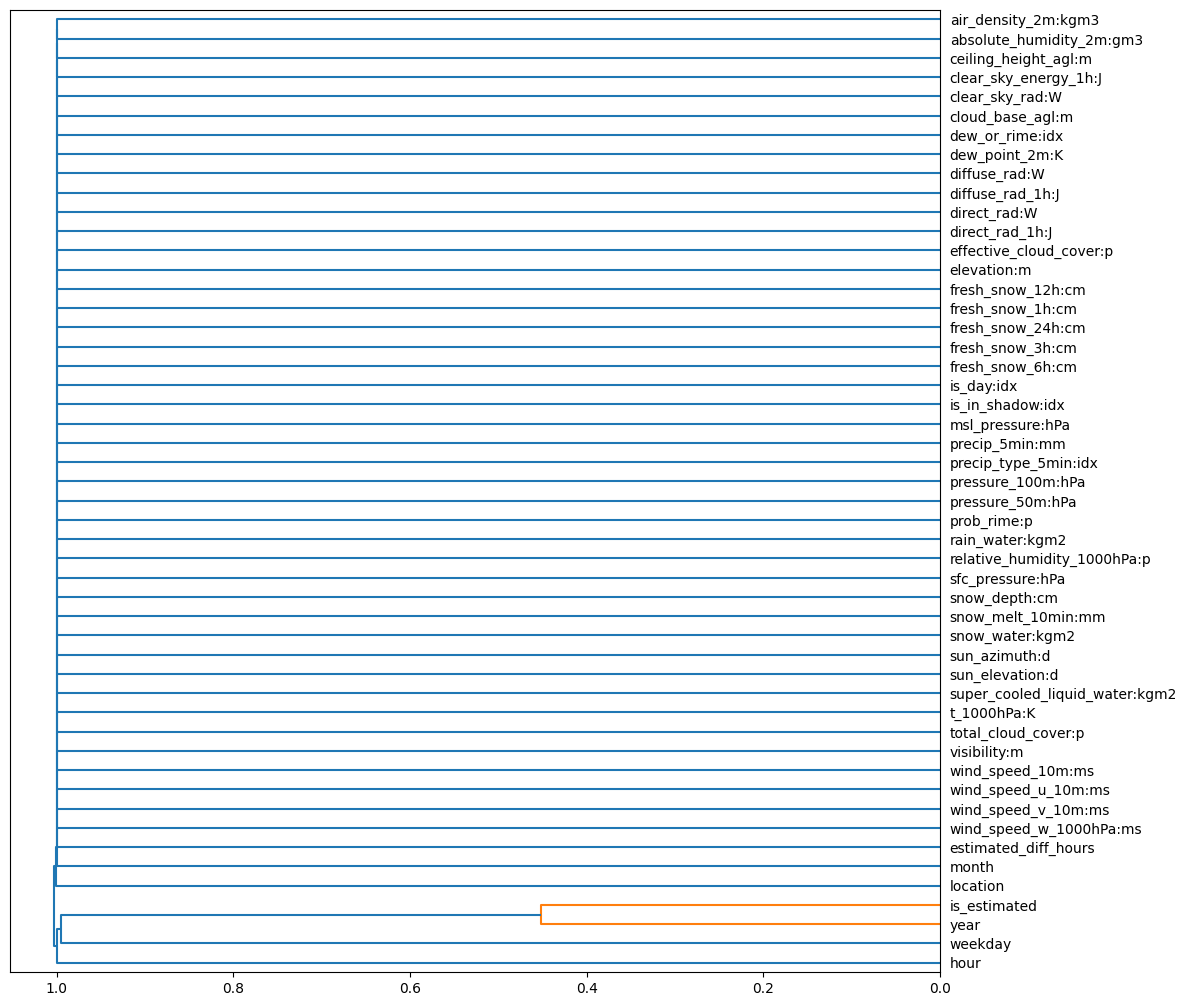

In [32]:
import autogluon.eda.auto as auto
auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,295.26029,787.46272,-0.0,0.0,0.0,176.4,5365.36,float64,2539,,,float,


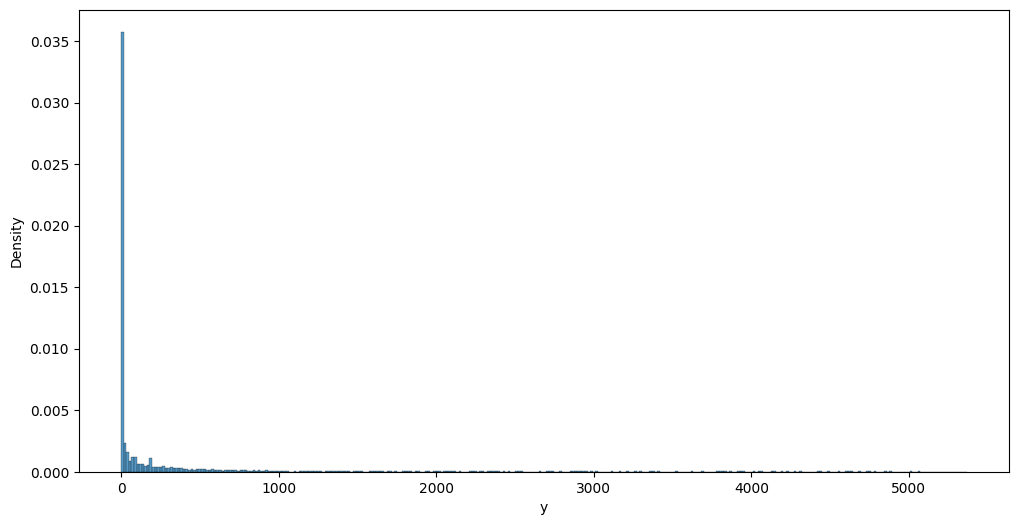

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

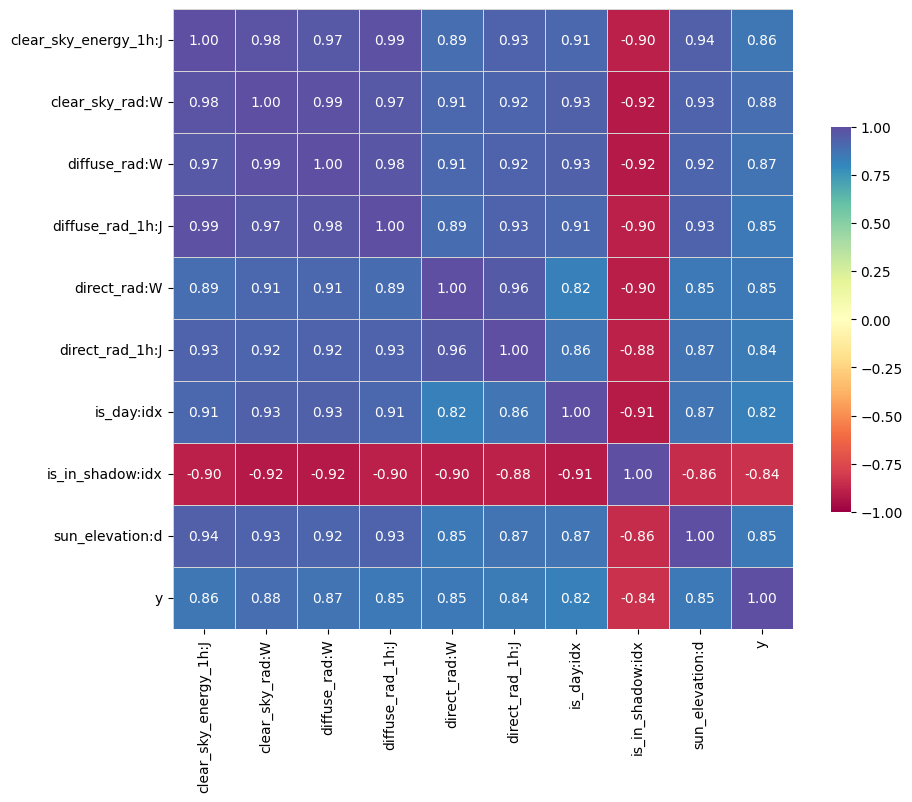

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

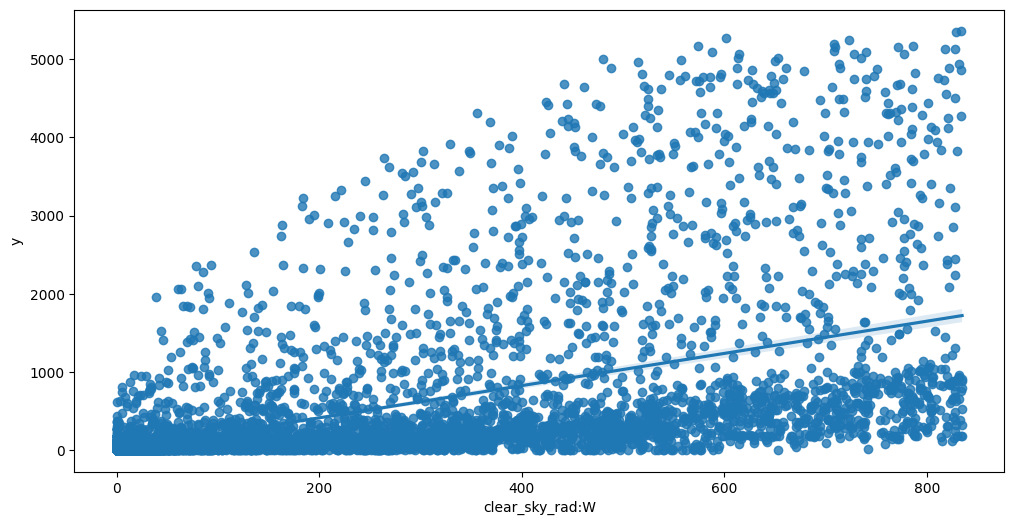

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

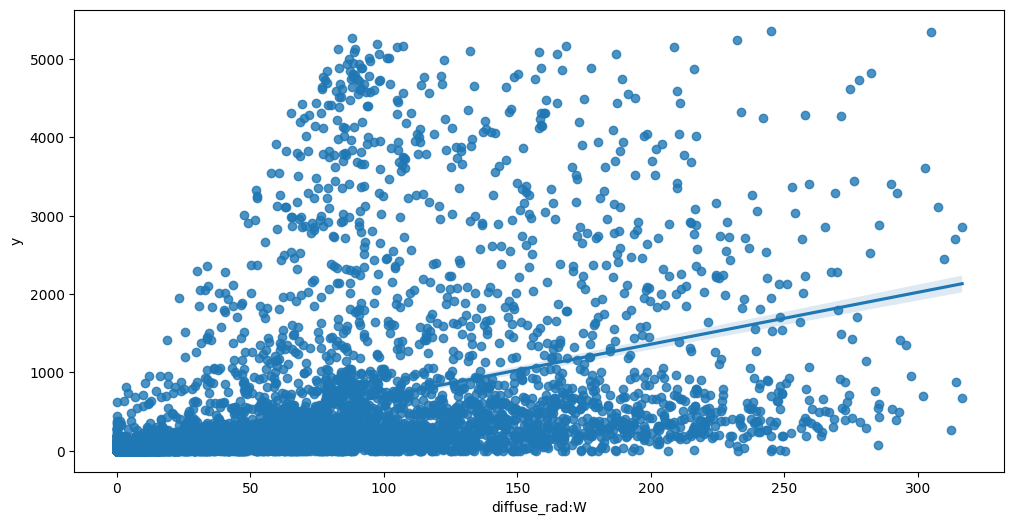

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

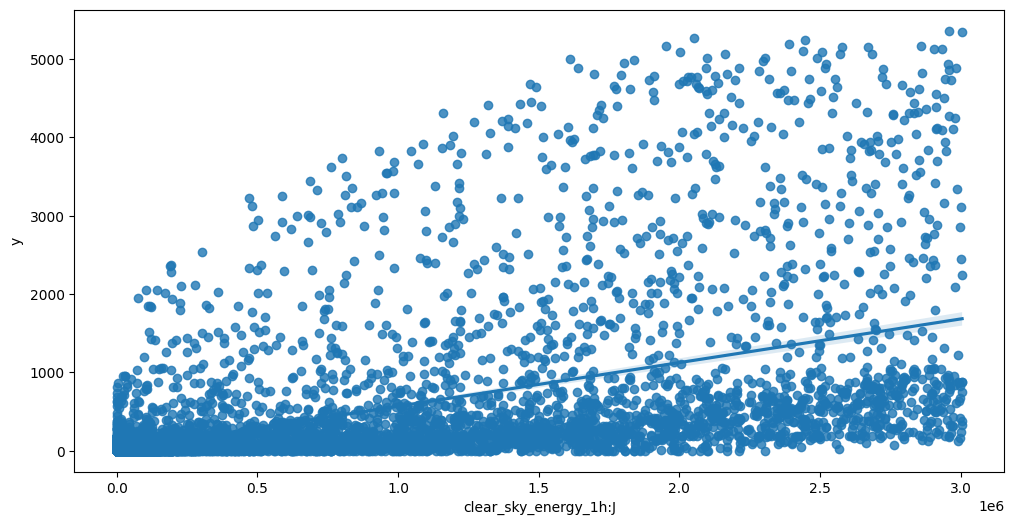

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

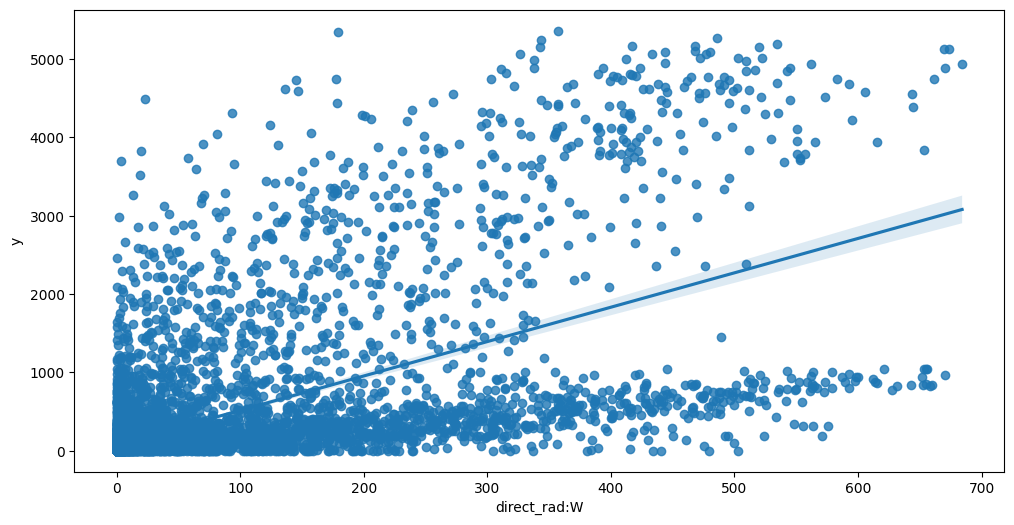

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

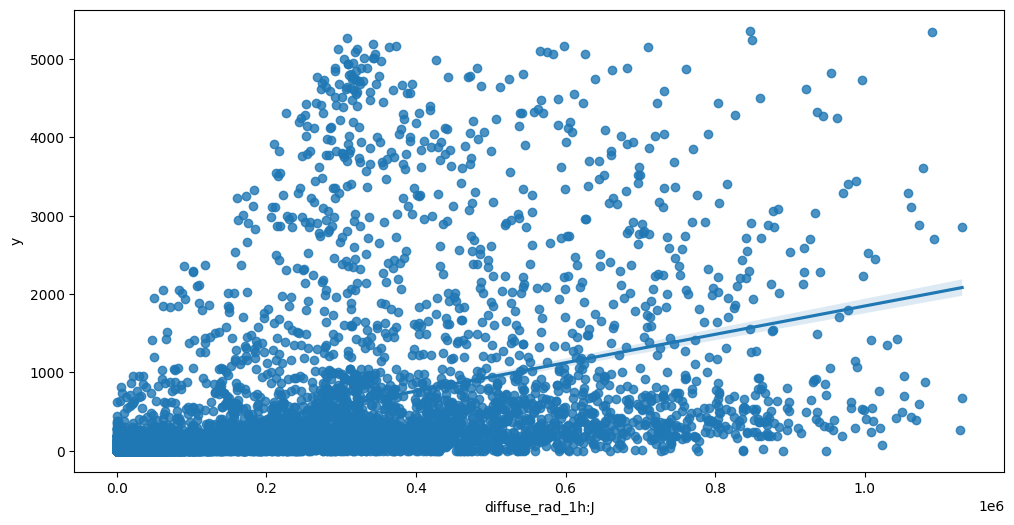

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

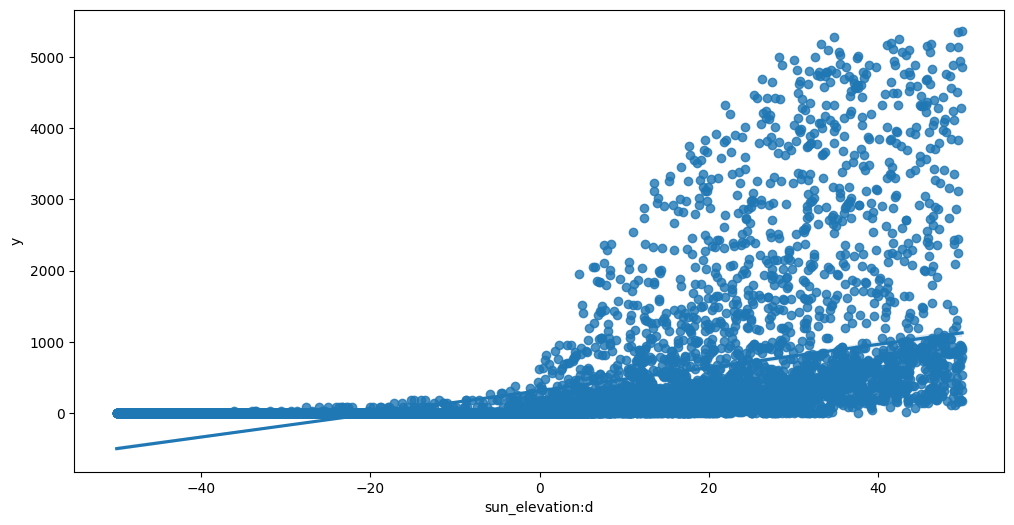

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

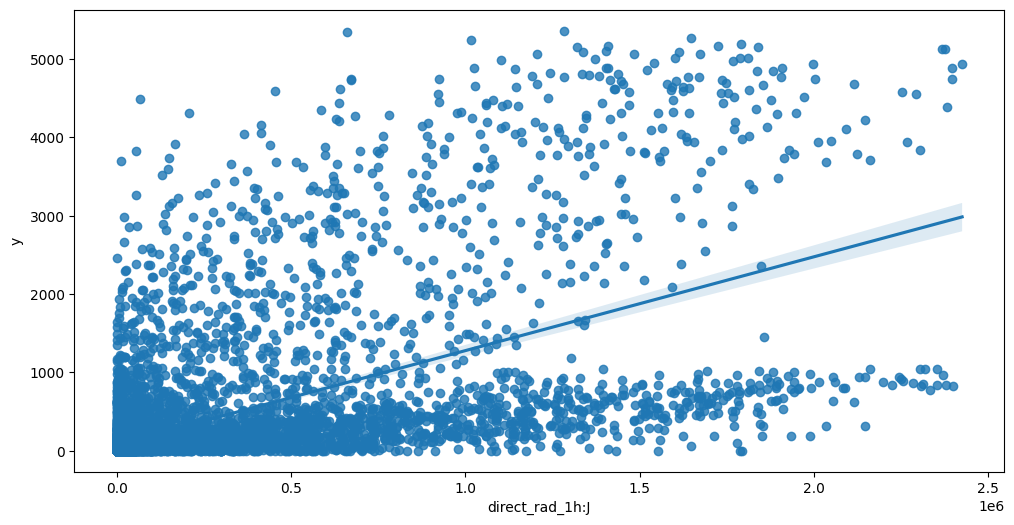

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

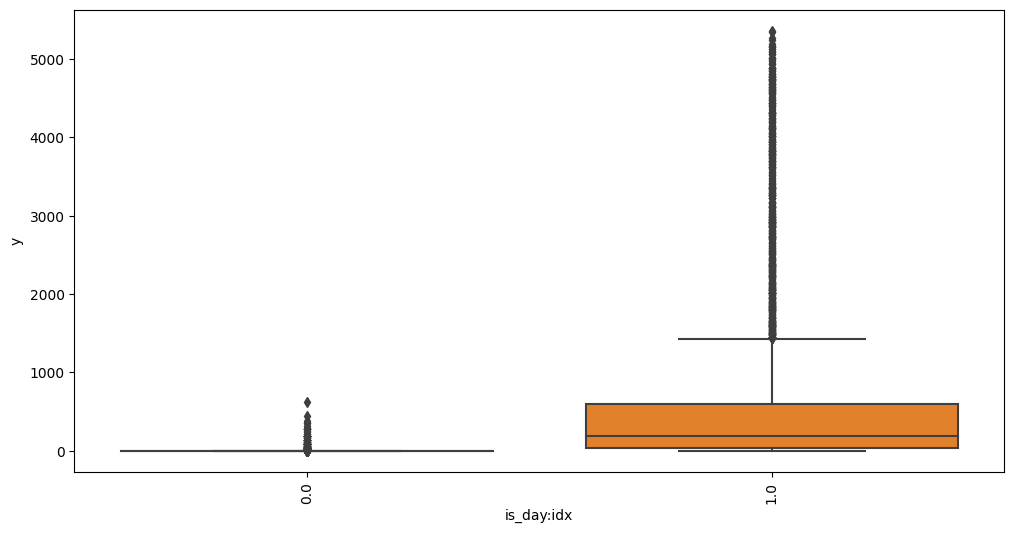

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

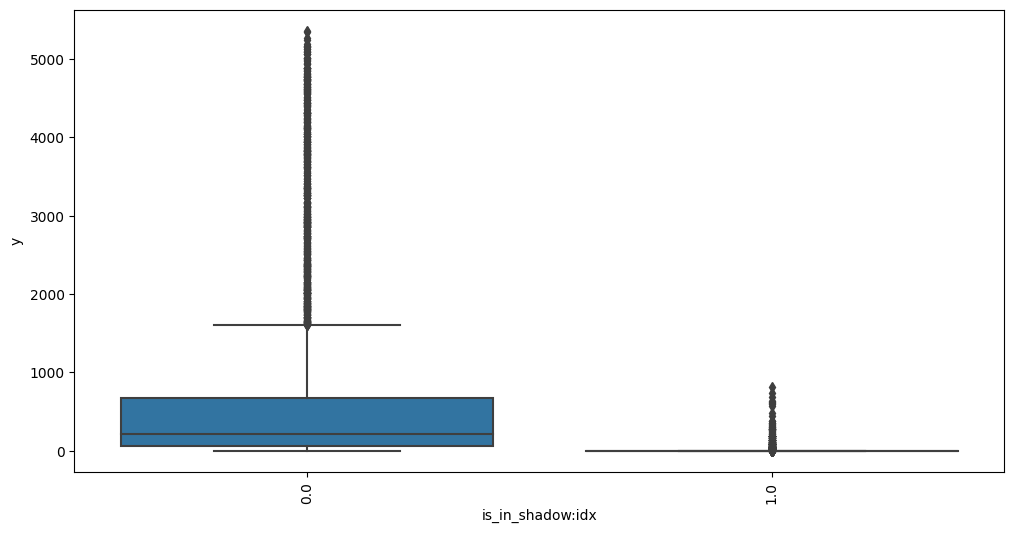

In [33]:
auto.target_analysis(train_data=X_train, label="y")#, sample=None)

No path specified. Models will be saved in: "AutogluonModels/ag-20231007_083734/"


### Model Prediction for y

Using validation data for `Test` points

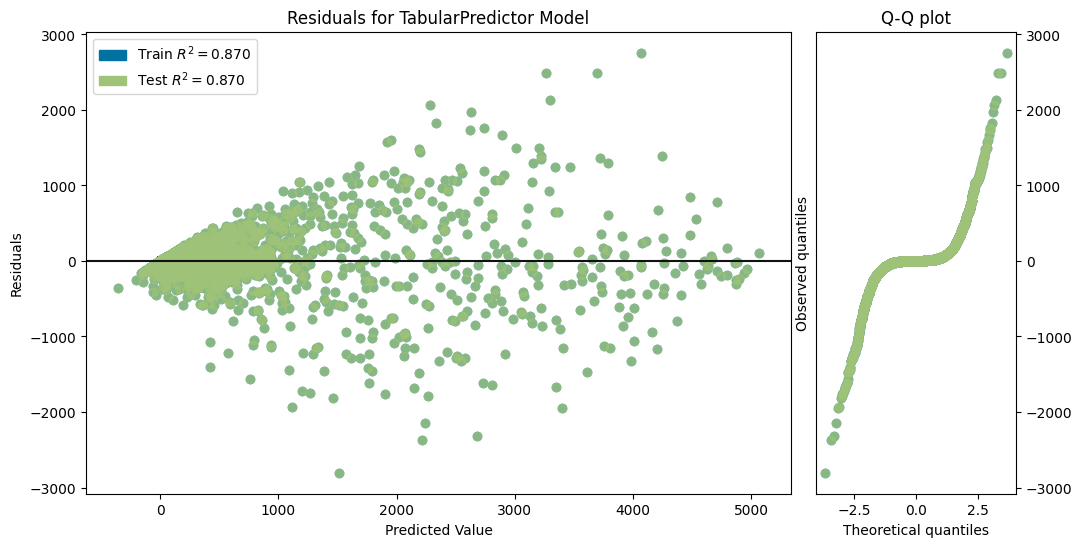

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-249.164477,-285.431722,0.143977,0.033739,32.57896,0.143977,0.033739,32.57896,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
location,331.696169,5.162675,7.040093e-09,5,342.326189,321.066149
direct_rad:W,174.475515,5.570827,1.245466e-07,5,185.945924,163.005105
clear_sky_rad:W,88.339881,4.673420,9.364283e-07,5,97.962518,78.717244
elevation:m,71.933615,0.736963,1.321831e-09,5,73.451032,70.416198
diffuse_rad:W,25.495976,3.292982,3.266283e-05,5,32.276272,18.715681
hour,24.161588,1.923359,4.778159e-06,5,28.121812,20.201365
sun_elevation:d,17.143152,2.022905,2.284024e-05,5,21.308342,12.977962
direct_rad_1h:J,16.726966,1.255815,3.784057e-06,5,19.312706,14.141227
sun_azimuth:d,14.771818,2.007006,3.990487e-05,5,18.904272,10.639365
effective_cloud_cover:p,6.673519,1.648372,4.125293e-04,5,10.067539,3.279499


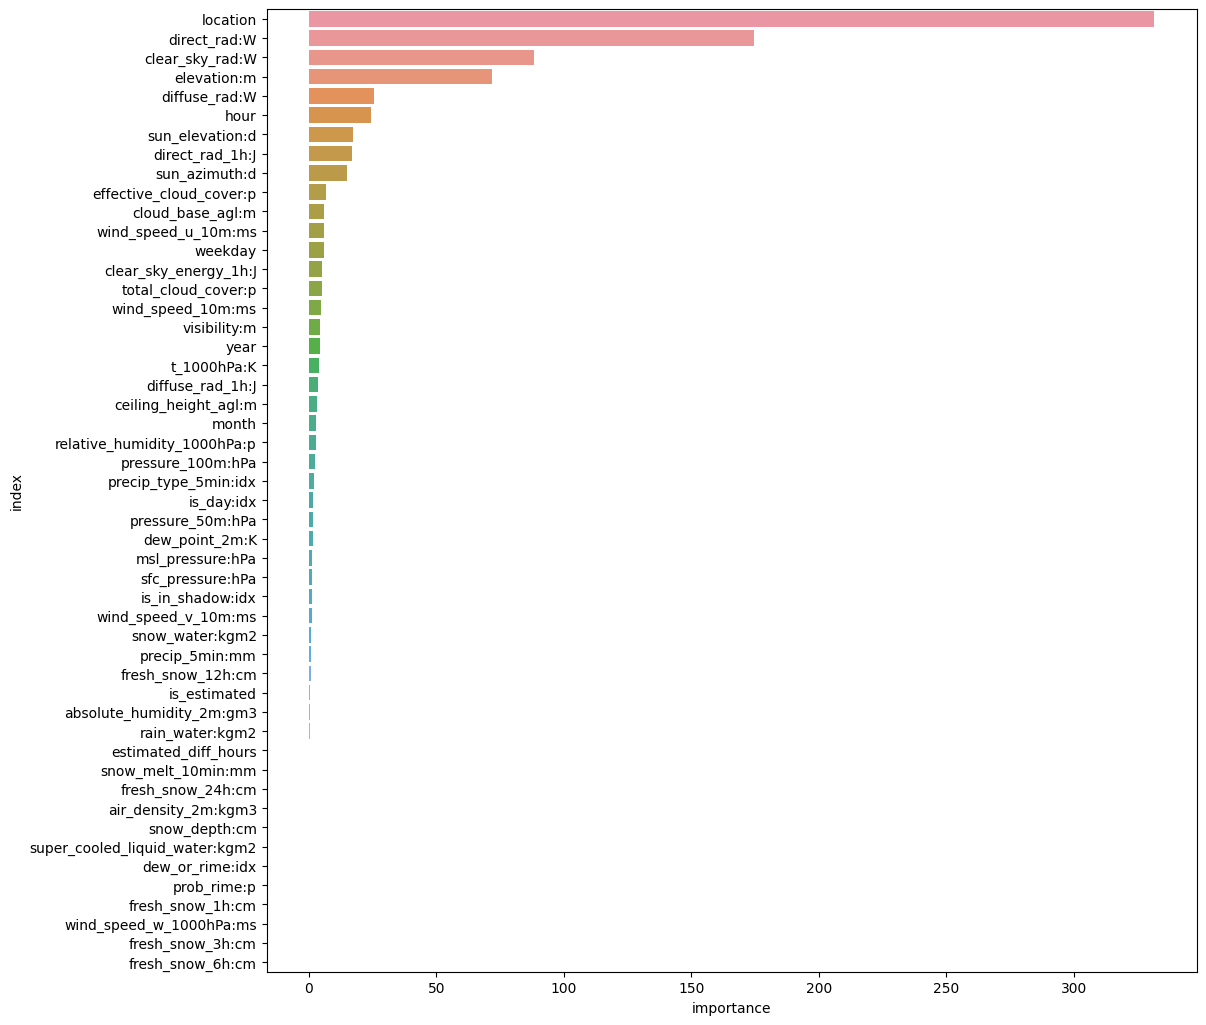

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,estimated_diff_hours,is_estimated,location,hour,weekday,month,year,y,y_pred,error
ds,,,,,,,,,,,,,,,,,,,,,
2021-08-31 12:00:00,10.6,1.240,932.400024,2157642.500,593.000000,210.199997,0.0,285.100006,160.399994,538968.31250,...,0.0,False,A,12,1,8,2021,4317.50,1513.236938,2804.263062
2022-04-19 08:00:00,5.4,1.243,NaN,1415330.750,452.500000,NaN,0.0,275.200012,79.800003,273179.90625,...,0.0,False,A,8,1,4,2022,1311.86,4069.547363,2757.687363
2022-04-19 08:00:00,5.4,1.238,NaN,1416421.750,452.899994,NaN,0.0,275.200012,80.599998,275853.40625,...,0.0,False,C,8,1,4,2022,490.00,500.201965,2757.687363
2022-04-19 08:00:00,5.4,1.238,NaN,1416421.750,452.899994,NaN,0.0,275.200012,80.599998,275853.40625,...,0.0,False,C,8,1,4,2022,490.00,4069.547363,2757.687363
2022-04-19 08:00:00,5.4,1.243,NaN,1415330.750,452.500000,NaN,0.0,275.200012,79.800003,273179.90625,...,0.0,False,A,8,1,4,2022,1311.86,500.201965,2757.687363
2019-08-24 10:00:00,10.4,1.214,1145.500000,2091485.250,612.299988,1145.500000,0.0,285.100006,217.100006,801617.87500,...,0.0,False,A,10,5,8,2019,768.90,3259.254150,2490.354150
2022-06-25 13:00:00,10.7,1.165,8184.100098,2917584.750,787.099976,2588.000000,0.0,286.000000,176.699997,539379.37500,...,0.0,False,A,13,5,6,2022,1200.32,3690.502930,2490.182930
2020-07-27 12:00:00,12.1,1.204,5779.100098,2775520.500,765.799988,2804.600098,0.0,287.299988,177.600006,562589.12500,...,0.0,False,A,12,0,7,2020,4585.46,2212.621582,2372.838418
2020-04-19 09:00:00,5.6,1.268,841.200012,1839072.625,557.700012,697.400024,0.0,275.600006,122.699997,426257.50000,...,0.0,False,A,9,6,4,2020,4993.12,2677.911621,2315.208379


In [34]:
auto.quick_fit(X_train, "y", show_feature_importance_barplots=True, val_size=0.3, sample=20000)

# Starting

In [35]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 82
Now creating submission number: 83
New filename: submission_83_jorge


In [36]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*10
presets = 'best_quality'

Loaded data from: X_train_raw.csv | Columns = 52 / 52 | Rows = 93024 -> 93024


In [ ]:
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}").fit(train_data, presets=presets, time_limit=time_limit)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 180s
AutoGluon will save models to "AutogluonModels/submission_82_jorge/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   19.58 GB / 494.38 GB (4.0%)
Train Data Rows:    136724
Train Data Columns: 50
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, -0.0, 247.8577, 717.45424)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary',

In [ ]:
predictors = [predictor, predictor, predictor]

# Submit

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 52 / 52 | Rows = 93024 -> 93024
Loaded data from: X_test_raw.csv | Columns = 51 / 51 | Rows = 2160 -> 2160


In [39]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [40]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

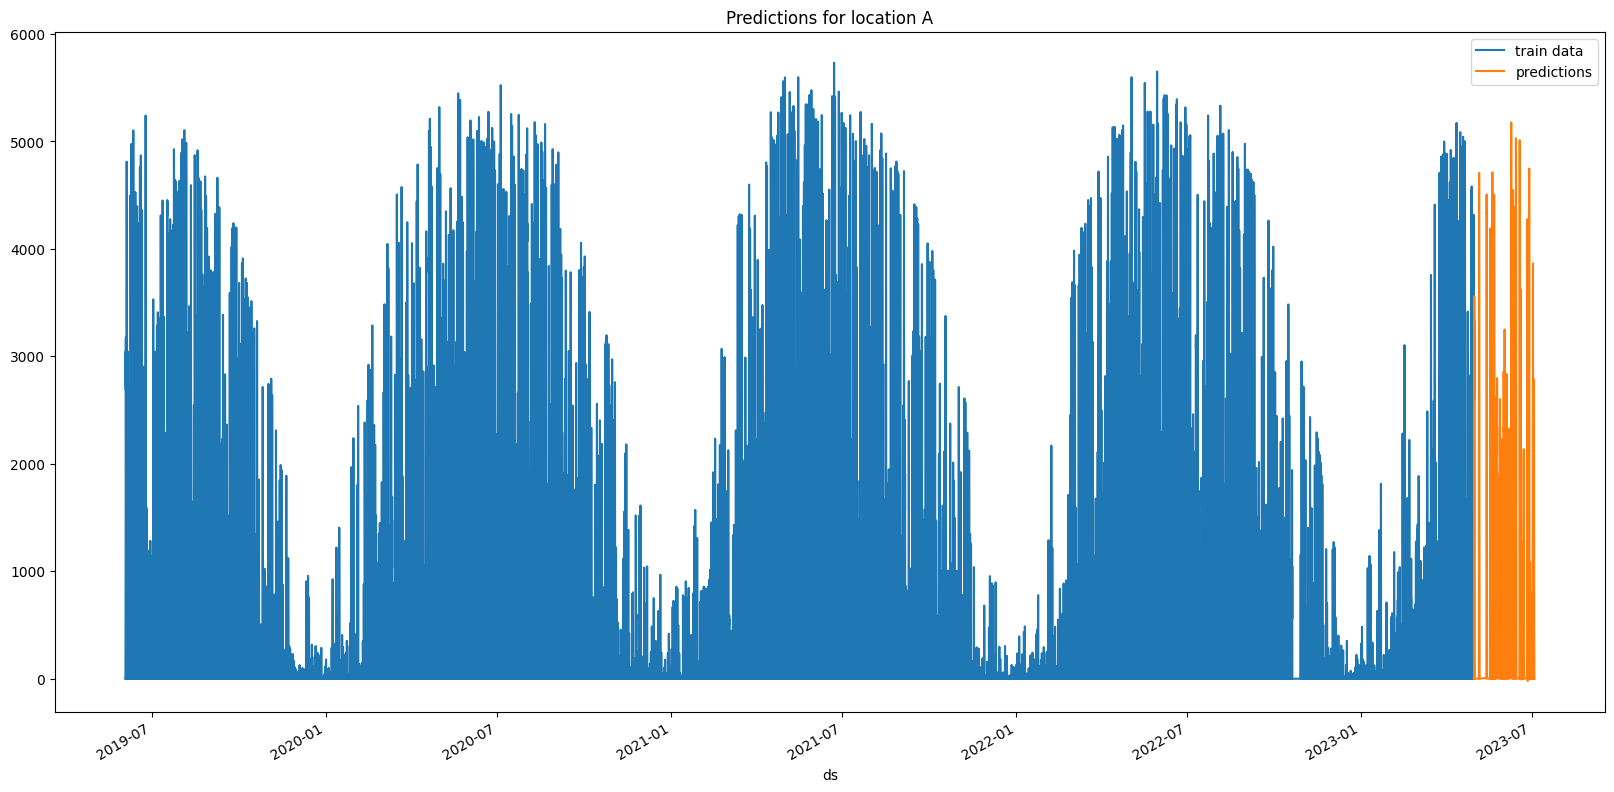

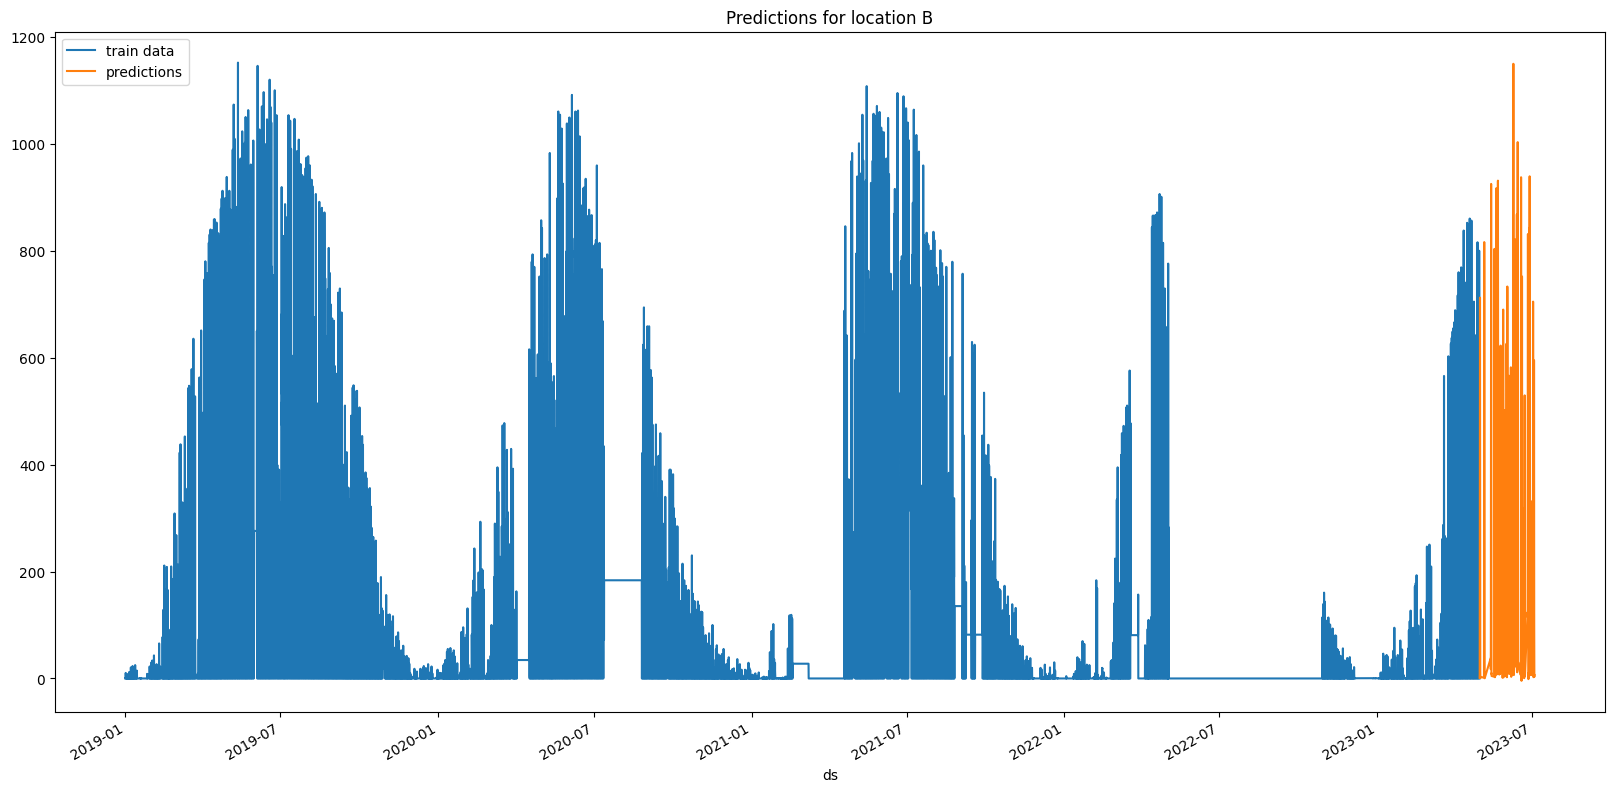

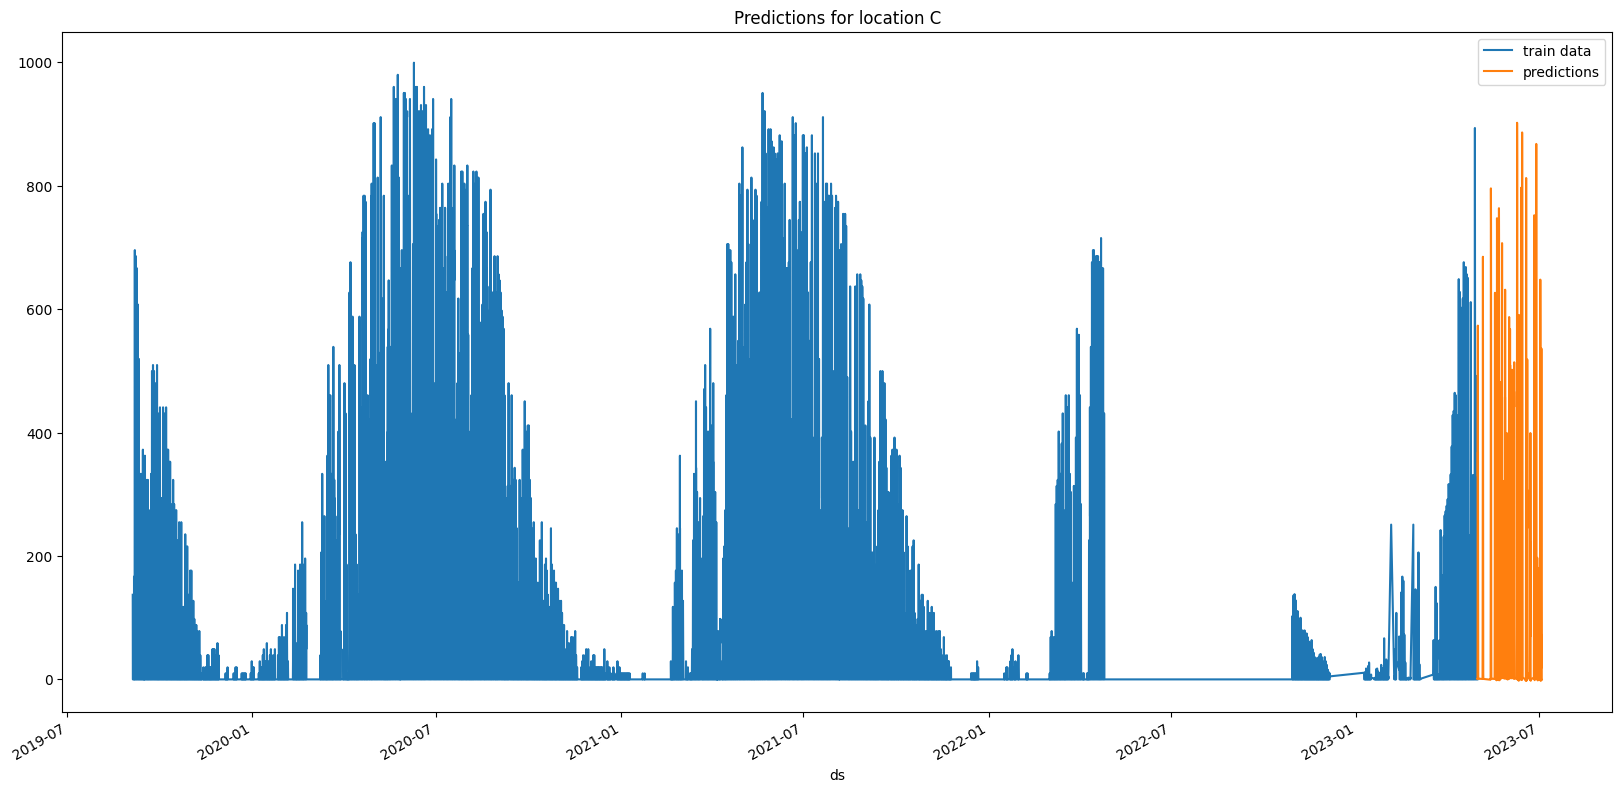

In [41]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [42]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,0.211684
1,1,0.516265
2,2,1.031603
3,3,52.105175
4,4,288.467529
...,...,...
715,2155,72.857269
716,2156,36.051491
717,2157,13.137769
718,2158,-1.017557


In [43]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_83_jorge.csv


In [44]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_all.ipynb"])

[NbConvertApp] Converting notebook autogluon_all.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_83_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_83_jorge_files/notebook_pdfs
[NbConvertApp] Writing 141076 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1716055 bytes to notebook_pdfs/submission_83_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_83_jorge.pdf', 'autogluon_all.ipynb'], returncode=0)

In [45]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    LightGBMXT_BAG_L2 -49.527149     451.300462  112.549396              202.476526          48.048242            2       True          4
1  WeightedEnsemble_L3 -49.527149     451.301551  112.551775                0.001090           0.002379            3       True          5
2  WeightedEnsemble_L2 -51.213662     248.825019   64.910360                0.001083           0.409206            2       True          3
3    LightGBMXT_BAG_L1 -51.217300     244.854969   57.026824              244.854969          57.026824            1       True          1
4      LightGBM_BAG_L1 -63.684434       3.968967    7.474330                3.968967           7.474330            1       True          2
Number of models trained: 5
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_LGB

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': -51.21730013851277,
  'LightGBM_BAG_L1': -63.684434475206324,
  'WeightedEnsemble_L2': -51.2136616576165,
  'LightGBMXT_BAG_L2': -49.527148759180335,
  'WeightedEnsemble_L3': -49.527148759180335},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBMXT_BAG_L1': 'AutogluonModels/submission_82_jorge/models/LightGBMXT_BAG_L1/',
  'LightGBM_BAG_L1': 'AutogluonModels/submission_82_jorge/models/LightGBM_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/submission_82_jorge/models/WeightedEnsemble_L2/',
  'LightGBMXT_BAG_L2': 'AutogluonModels/submission_82_jorge/models/LightGBMXT_BAG_L2/',
  'WeightedEnsemble_L3': 'AutogluonModels/submission_82_jorge/models/WeightedEnsemble_L

,ds,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated_diff_hours,is_estimated,y,location,hour,weekday,month,year
0,2019-06-02 22:00:00,7.7,1.230,1744.9,0.0,0.0,1744.9,0.0,280.3,0.0,...,-0.8,-0.0,0.0,False,0.00,A,22,6,6,2019
1,2019-06-02 23:00:00,7.7,1.225,1703.6,0.0,0.0,1703.6,0.0,280.3,0.0,...,0.0,-0.0,0.0,False,0.00,A,23,6,6,2019
2,2019-06-03 00:00:00,7.7,1.221,1668.1,0.0,0.0,1668.1,0.0,280.2,0.0,...,0.7,-0.0,0.0,False,0.00,A,0,0,6,2019
3,2019-06-03 01:00:00,8.2,1.218,1388.4,0.0,0.0,1388.4,0.0,281.3,0.0,...,0.8,-0.0,0.0,False,0.00,A,1,0,6,2019
4,2019-06-03 02:00:00,8.8,1.219,1108.5,6546.9,9.8,1108.5,0.0,282.3,4.3,...,1.0,-0.0,0.0,False,19.36,A,2,0,6,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93019,2023-04-30 19:00:00,4.4,1.274,1474.2,156770.7,13.4,557.0,0.0,272.1,8.8,...,1.8,-0.0,35.0,True,50.96,C,19,6,4,2023
93020,2023-04-30 20:00:00,4.4,1.278,1427.3,7917.1,0.0,541.7,0.0,272.0,0.0,...,1.9,-0.0,36.0,True,2.94,C,20,6,4,2023
93021,2023-04-30 21:00:00,4.4,1.279,1558.1,0.0,0.0,601.5,0.0,271.9,0.0,...,2.4,-0.0,37.0,True,0.00,C,21,6,4,2023
93022,2023-04-30 22:00:00,4.4,1.279,1446.6,0.0,0.0,540.7,0.0,271.9,0.0,...,2.4,-0.0,38.0,True,-0.00,C,22,6,4,2023


In [53]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictor.feature_importance(feature_stage="original", data=estimated)

These features in provided data are not utilized by the predictor and will be ignored: ['ds']
Computing feature importance via permutation shuffling for 50 features using 4418 rows with 5 shuffle sets...
	2640.42s	= Expected runtime (528.08s per shuffle set)


KeyboardInterrupt: 

In [ ]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictor.feature_importance(feature_stage="original", data=observed)

Computing feature importance via permutation shuffling for 50 features using 5000 rows with 10 shuffle sets... Time limit: 120s...


	6376.36s	= Expected runtime (637.64s per shuffle set)
	505.35s	= Actual runtime (Completed 1 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,225.838822,NaN,NaN,1,NaN,NaN
clear_sky_rad:W,208.653183,NaN,NaN,1,NaN,NaN
diffuse_rad:W,91.020893,NaN,NaN,1,NaN,NaN
sun_elevation:d,84.803063,NaN,NaN,1,NaN,NaN
clear_sky_energy_1h:J,41.630369,NaN,NaN,1,NaN,NaN
hour,39.231764,NaN,NaN,1,NaN,NaN
sun_azimuth:d,38.369715,NaN,NaN,1,NaN,NaN
cloud_base_agl:m,31.783934,NaN,NaN,1,NaN,NaN
weekday,28.542697,NaN,NaN,1,NaN,NaN
direct_rad_1h:J,28.482953,NaN,NaN,1,NaN,NaN


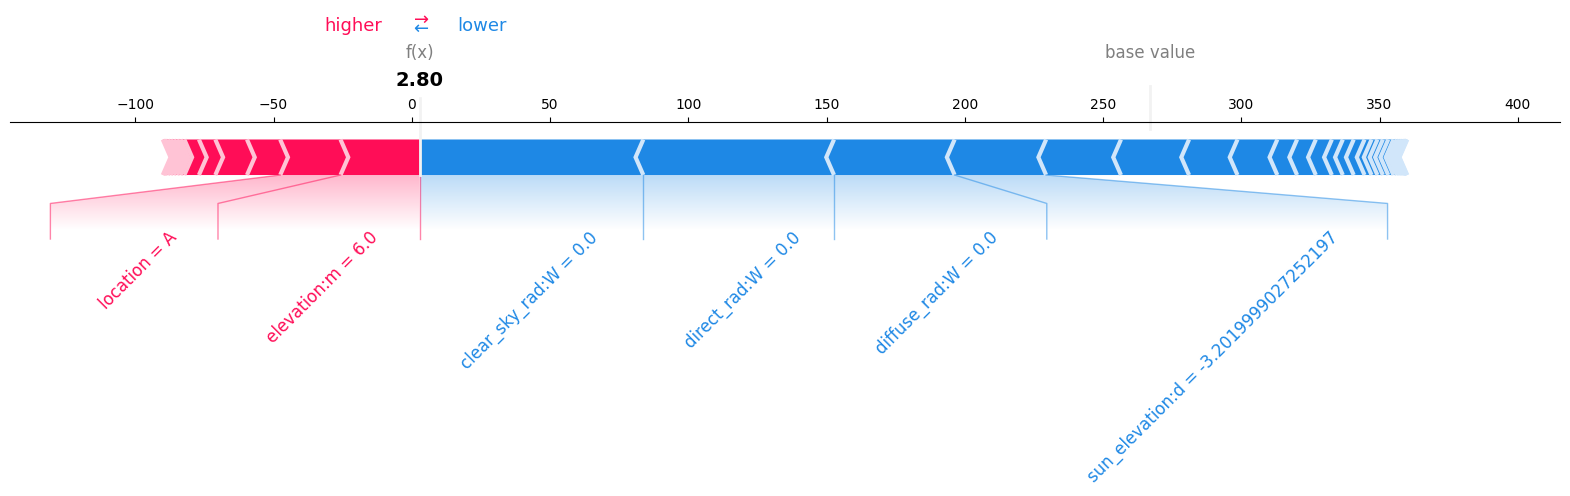

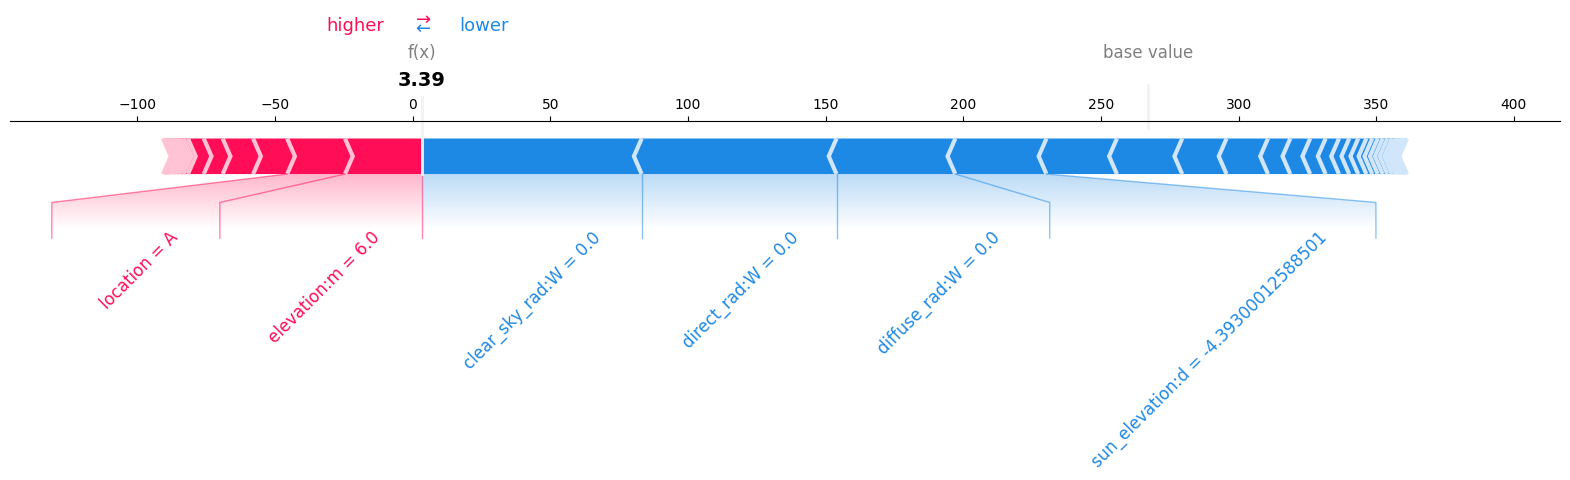

In [ ]:
#auto.explain_rows(train_data=X_train, model=predictor, plot="force", rows=X_train[:1])

In [ ]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_all.ipynb"])

[NbConvertApp] Converting notebook autogluon_all.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_82_jorge_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_82_jorge_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 121656 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2064363 bytes to notebook_pdfs/submission_82_jorge_with_feature_importance.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_82_jorge_with_feature_importance.pdf', 'autogluon_all.ipynb'], returncode=0)